<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/bias_variance_tradeoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustrate bias-variance tradeoff

Using a concrete linear regression example:

$y = \beta_1 x_1 + \beta_2 x_2 + \epsilon$

There is substantial **collinearity** between $x_1$ and $x_2$, hence high variance. **Ridge regression** *introduces bias, but reduces variance*, and may do better overall. 

In [0]:
from __future__ import division, print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [0]:
n = 100  # number of samples
b = [1, 2]
b1, b2 = b[0], b[1]

sigma = 0.1  # noise
k = 10000  # number of repeats 
alphas = [0.001, 0.01, 0.1, 1, 10]  # aka lambdas
p = 2  # dimension of parameter space

np.random.seed(0)

# high correlation / substantial collinearity
X = np.random.multivariate_normal([0,0], [[1,0.9999],[0.9999,1]], size=n)
x1, x2 = X[:,0], X[:,1]
f = b1*x1 + b2*x2

U, s, Vt = np.linalg.svd(X)

# a new sample
xi = np.array([[1, 2]])
fi = xi[0,0]*b1 + xi[0,1]*b2

In [0]:
out = []
np.random.seed(0)

for alpha in alphas:
    for i in range(k):
        y = f + np.random.randn(n)*sigma
        yi = fi + np.random.randn()*sigma
        
        ridge = Ridge(fit_intercept=False, alpha=alpha).fit(X, y)
        
        yhi = ridge.predict(xi)[0]
        
        mse = mean_squared_error([yi], [yhi])
        
        out.append((alpha, i, yhi, mse))
        
df = pd.DataFrame(out, columns=['alpha', 'rep', 'yhi', 'mse'])

In [0]:
bias2s = (fi - df.groupby('alpha').apply(lambda tab: tab.yhi.mean()))**2

variances = df.groupby('alpha').apply(lambda tab: tab.yhi.var())

mses = df.groupby('alpha').apply(lambda tab: tab.mse.mean())

$\langle (y_i - \hat{y}_i)^2 \rangle \\
= (x_i^T D \beta)^2 \; + \; \sigma^2 b^T b \; + \; \sigma^2$

* the first term is the bias term and $\displaystyle D = D(\lambda) = I - V \; \text{diag}\Big( \frac{\sigma^2}{\sigma^2+\lambda} \Big) \; V^T$ (so $D(0) = 0$)
* the second term is the variance term and $\displaystyle b^T b = x_i^T V \;  \text{diag} \Big( \frac{\sigma^2}{(\sigma^2+\lambda)^2} \Big) \;  V^T x_i$ (so as $\lambda$ goes to 0, the terms goes to $\displaystyle x_i^T V \;  \text{diag} \Big( \frac{1}{\sigma^2} \Big) \;  V^T x_i$)

In [0]:
def alpha2bias_pred(alpha):
    D = np.identity(p) - np.dot(np.dot(Vt.T, np.diag(s**2/(s**2+alpha))), Vt)
    return np.dot(np.dot(xi, D), b)[0]

bias2s_pred = np.array([alpha2bias_pred(alpha)**2 for alpha in alphas])

In [0]:
def alpha2variance_pred(alpha):
    diag = np.diag(s**2/(s**2+alpha)**2)
    Vtxi = np.dot(Vt, xi.T)
    return np.dot(np.dot(Vtxi.T, diag), Vtxi)[0,0] * sigma**2

variances_pred = np.array([alpha2variance_pred(alpha) for alpha in alphas])

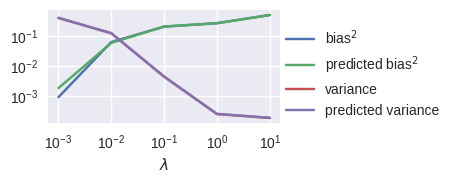

In [7]:
fig, ax = plt.subplots(figsize=(3,1.5), dpi=100)
ax.plot(alphas, bias2s, label='bias'+r'$^2$')
ax.plot(alphas, bias2s_pred, label='predicted bias'+r'$^2$')
ax.plot(alphas, variances, label='variance')
ax.plot(alphas, variances_pred, label='predicted variance')

ax.set_xlabel(r'$\lambda$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=(1,0))
plt.show()

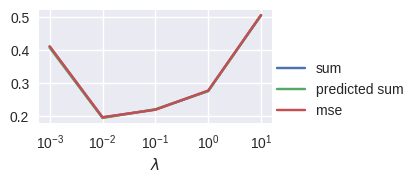

In [8]:
fig, ax = plt.subplots(figsize=(3,1.5), dpi=100)

ax.plot(alphas, bias2s+variances+sigma**2, label='sum')
ax.plot(alphas, bias2s_pred+variances_pred+sigma**2, label='predicted sum')
ax.plot(alphas, mses, label='mse')

ax.set_xlabel(r'$\lambda$')

ax.set_xscale('log')
ax.legend(loc=(1,0))
plt.show()